In [27]:
import json
import nltk
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pylab as plt
from collections import Counter
from functools import partial
from ast import literal_eval
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from artemis.utils.basic import df_parallel_column_apply
from artemis.analysis.utils import contains_word, contains_bigrams, concreteness_of_sentence, pos_analysis
from artemis.language.basics import tokenize_and_spell, ngrams
from artemis.language.part_of_speech import nltk_parallel_tagging_of_tokens
from artemis.utils.visualization import plot_overlayed_two_histograms
from artemis.utils.other_datasets.flickr30K_entities import load_all_linguistic_annotations
from artemis.utils.other_datasets.conceptual_captions import load_conceptual_captions
from artemis.utils.other_datasets.google_refexp import load_google_refexp_captions

sns.set()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
try:
    from textblob import TextBlob    
except:
    print('For analyzing the subjectivity (bottom parts of notebook) you need to install textblob')  
    print('e.g., conda install -c conda-forge textblob')

In [29]:
freq_file = '/media/data/LuoTing/local/work_space/artemis-master/artemis/data/symspell_frequency_dictionary_en_82_765.txt'
glove_file = '/media/data/LuoTing/local/work_space/artemis-master/artemis/data/glove.6B.100d.vocabulary.txt'

## Use your path:
artemis_preprocessed_csv = '/media/data/LuoTing/local/work_space/out/step_1/All_dataset/artemis_preprocessed.csv'

brm_file=\
'/media/data/LuoTing/local/work_space/artemis-master/RAIVS/scripts/test/Concreteness_ratings_Brysbaert_et_al_BRM.xlsx'

##
## Hyper-params for notebook 
##
load_ela = True
brm_drop_articles = True # use or not the: "the", "a", "an", "every".
spell_check_non_artemis_data = False


### Load -datasets-
datasets = dict()
if load_ela:
    df = pd.read_csv(artemis_preprocessed_csv)
    df.tokens = df.tokens.apply(literal_eval)
    datasets['ArtEmis'] = df

#平均长度：
for k, v in datasets.items():
    print(k, 'N-sentences:', len(v), 'Average Length:', v.tokens_len.mean().round(1))


ArtEmis N-sentences: 429431 Average Length: 14.7


In [30]:

#抽象性分析：
##
## Conreteness Analysis
##
brm_data = pd.read_excel(brm_file)
brm_data.Word = brm_data.Word.apply(lambda x: str(x).lower())

if brm_drop_articles:
    brm_data = brm_data[brm_data.Dom_Pos != 'Article']
    
brm_data = brm_data[['Word', 'Conc.M']]
brm_data.columns = ['word', 'concreteness']
word_to_concreteness = dict(zip(brm_data.word, brm_data.concreteness))

concreteness_scores = dict()
for dset_name in datasets:    
    concreteness_scores[dset_name] = datasets[dset_name].tokens.apply(lambda x: concreteness_of_sentence(x, word_to_concreteness))    
    smean = concreteness_scores[dset_name].mean().round(2)
    smedian = concreteness_scores[dset_name].median().round(2)#能够返回给定数值的中值，
    print(dset_name, 'concreteness(均值，中位数)', smean, smedian)

# restrict to the most abstract words, bigrams (per percentile value). How many of those are precent in eaach dataset?
wc_vals = list(word_to_concreteness.values())
prc = 1
conc_threshold = np.percentile(wc_vals, prc)
abstract_unigrams = set()
abstract_bigrams = set()
for k, v in word_to_concreteness.items():
    if v <= conc_threshold:
        if ' ' in k:
            abstract_bigrams.add(k)
        else:
            abstract_unigrams.add(k)            

print('Percentile of most abstract:', prc)
print('Number of words/bigrams to be used as abstract:（抽象词，抽象元组）', len(abstract_unigrams), len(abstract_bigrams))

uses_abstract = contains_word(datasets['ArtEmis'].tokens, abstract_unigrams)
uses_abstract |= datasets['ArtEmis'].tokens.apply(partial(contains_bigrams, abstract_bigrams))
print('使用抽象元组的均值：',uses_abstract.mean())


ArtEmis concreteness(均值，中位数) 2.81 2.79
Percentile of most abstract: 1
Number of words/bigrams to be used as abstract:（抽象词，抽象元组） 424 4
使用抽象元组的均值： 0.2991935840682205


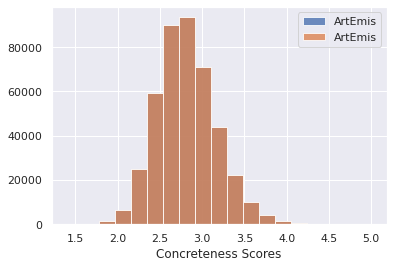

In [31]:
x1 = concreteness_scores['ArtEmis'][~concreteness_scores['ArtEmis'].isna()]

fig = plot_overlayed_two_histograms( x1,x1, min_val=1.4, max_val=5.0, 
                                    n_bins=20, alpha=0.8, labels=[ 'ArtEmis','ArtEmis']);

fig.axes[0].set_xlabel('Concreteness Scores')
fig.savefig('ArtEmis_vs_COCO_concreteness.jpg')

In [32]:
#中位数
x1.median()

2.79

In [33]:
##
## Sentiment Analysis
##

def vader_classify(score, threshold=0.05):
    if abs(score) < threshold:
        return 'neutral'

    if score > 0:
        return 'positive'

    if score < 0:
        return 'negative'
    
def vader_score(sentence):
    return vader.polarity_scores(sentence)['compound']
sentiment_scores = dict()
vader = SentimentIntensityAnalyzer()

for dset_name in datasets:    
    sentiment_scores[dset_name] = datasets[dset_name]['utterance_spelled'].apply(lambda x: vader.polarity_scores(x)['compound'])
    scores = sentiment_scores[dset_name]
    smean = scores.abs().mean().round(2)
    smedian = scores.abs().median().round(2)    
    print(dset_name, 'sentiment-score（均值，中位数）', smean, smedian)

sentiment_classes_list = []  # aggregate for all datasets to make a nice plot
dataset_names = []
sentiment_classes = dict()
threshold = 0.05
for name in sentiment_scores:
    temp = sentiment_scores[name].apply(lambda x: vader_classify(x, threshold=threshold))
    sentiment_classes[name] = temp    
    sentiment_classes_list.extend(temp.to_list())
    dataset_names.extend(len(temp) * [name])   

#中性情感词均分
for name in sentiment_classes:
    print('中性情感词均分',name, (sentiment_classes[name] == 'neutral').mean())


ArtEmis sentiment-score（均值，中位数） 0.43 0.44
中性情感词均分 ArtEmis 0.1695219953845903


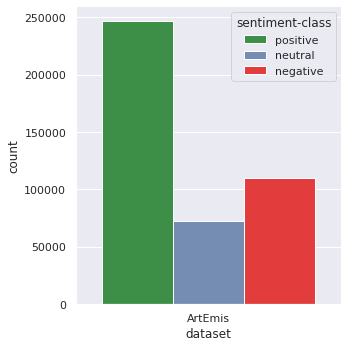

In [34]:
d1 = pd.DataFrame(dataset_names, columns=['dataset'])
d2 = pd.DataFrame(sentiment_classes_list, columns=['sentiment-class'])
aggregate_sentiment_stats = pd.concat([d1, d2], axis=1)
c = sns.catplot(x="dataset", 
                hue="sentiment-class", 
                data=aggregate_sentiment_stats, 
                kind="count",                 
                palette={"negative": "#FE2020", 
                         "positive": "#2f9c3b", 
                         "neutral": "#6b8abd"},                                
                legend_out=False,
               )
c.savefig('ArtEmis_vs_COCO_sentiment_classes.jpg')

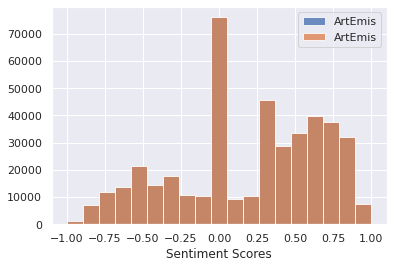

In [35]:
fig= plot_overlayed_two_histograms(sentiment_scores['ArtEmis'], 
                              sentiment_scores['ArtEmis'], 
                              min_val=-1, max_val=1, n_bins=20, labels=['ArtEmis', 'ArtEmis']);
fig.axes[0].set_xlabel('Sentiment Scores')
fig.savefig('ArtEmis_vs_COCO_sentiment_scores.jpg')

In [36]:
## 主观性得分
## Subjectivity Analysis
##
def subjectivity(utterance):
    testimonial = TextBlob(utterance)
    return testimonial.sentiment.subjectivity

#具有主观性得分1
print(TextBlob('The painting is red').sentiment.subjectivity)
print(TextBlob('The painting is nice').sentiment.subjectivity)

subjectivity_scores = dict()
for dset_name in datasets:    
    subjectivity_scores[dset_name] = df_parallel_column_apply(datasets[dset_name], subjectivity, 'utterance_spelled')

print(subjectivity_scores['ArtEmis'].mean().round(2))
print(subjectivity_scores['ArtEmis'].median().round(2))

0.0
1.0
0.47
0.5


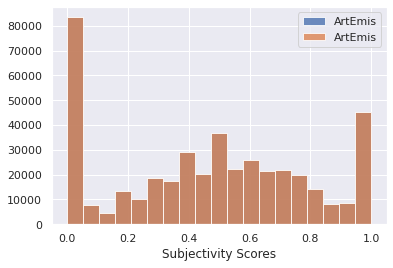

In [37]:
fig = plot_overlayed_two_histograms(subjectivity_scores['ArtEmis'], 
                              subjectivity_scores['ArtEmis'], 
                              min_val=0, max_val=1, n_bins=20, labels=['ArtEmis', 'ArtEmis']);
fig.axes[0].set_xlabel('Subjectivity Scores')
fig.savefig('ArtEmis_vs_COCO_subjectivity_scores.jpg')

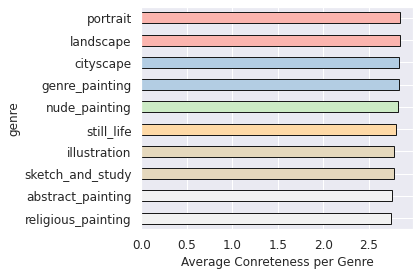

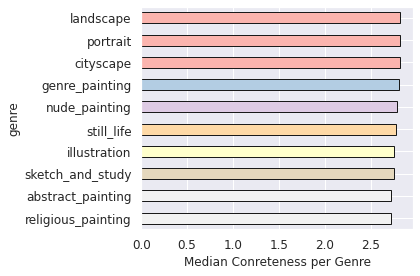

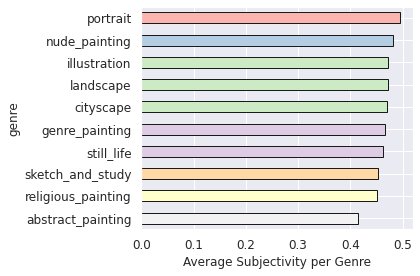

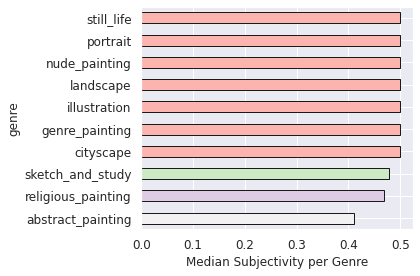

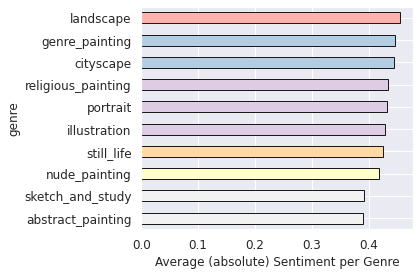

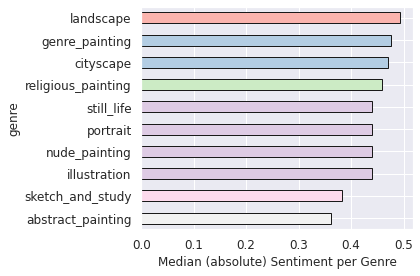

In [38]:
## 词性丰富性
## Analyze the above metric per art-genre
##
name = 'ArtEmis'
datasets[name]['conreteness_scores'] = concreteness_scores[name]    
datasets[name]['subjectivity_scores'] = subjectivity_scores[name]
datasets[name]['sentiment_abs_scores'] = sentiment_scores[name].abs()

g = pd.read_csv('../../artemis/data/wiki_art_genre_class.csv')
m = pd.merge(datasets['ArtEmis'], g, on=['art_style', 'painting'])
pallete = plt.cm.Pastel1_r

for metric in ['conreteness_scores', 'subjectivity_scores', 'sentiment_abs_scores']:
    for stat in ['average', 'median']:
        
        if stat == 'average':
            s = m.groupby('genre')[metric].mean().sort_values()
        else:
            s = m.groupby('genre')[metric].median().sort_values()
            
        fig = plt.figure()
        norm = plt.Normalize(s.min(), s.max())
        colors = pallete(norm(s.values))                
        ax = s.plot.barh(grid=True, color=colors, ec="k", fontsize=12)        

        name_of_metric = metric.split('_')[0].capitalize()
        
        if metric == 'sentiment_abs_scores':                        
            xlabel = '{} (absolute) Sentiment per Genre'.format(stat.capitalize())
        else:            
            xlabel = '{} {} per Genre'.format(stat.capitalize(), name_of_metric)        
        
        ax.set_xlabel(xlabel)
        plt.tight_layout()        
        fig.savefig('ArtEmis_{}_per_Genre_{}.jpg'.format(name_of_metric, stat.capitalize()))

In [39]:
##
## Analyze basic linguistic elements: Part-Of-Speech
##
for df in datasets.values():
    df['pos'] = nltk_parallel_tagging_of_tokens(df.tokens)

# (raw numbers of Table.1 in main papeer)
for dataset_name, df in datasets.items():
    print(dataset_name)
    pos_analysis(df)

ArtEmis
Nouns 3.7
Pronouns 0.8
Adjectives 1.5
Adpositions 1.8
Verbs 2.8


In [40]:
# Below group the utterances first along each image (stimulus).
# Numbers of Table.2 in main paper
pos_analysis(datasets['ArtEmis'], group_cols=['painting', 'art_style'])

  0%|          | 0/80030 [00:00<?, ?it/s]

Nouns 16.8 3.2
Pronouns 2.8 0.6
Adjectives 7.4 1.4
Adpositions 5.9 1.2
Verbs 11.9 2.3
